# Scale Volumes

This script runs exactly the same model as in simpleBis.py, but it 
automatically scales the volumes from 1e-19 down to smaller values.

Note how the simulation successively becomes noisier, until
at very small volumes there are spontaneous state transitions. 

vol = 1e-19, a.concInit = 1.0, a.nInit = 60221.415
Close graph to go to next plot



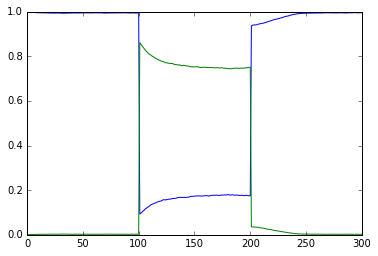

vol = 1e-20, a.concInit = 1.0, a.nInit = 6022.1415
Close graph to go to next plot



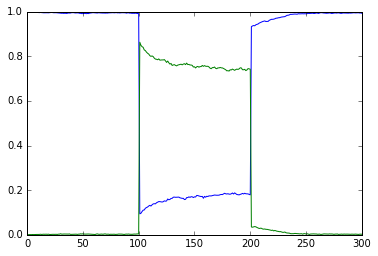

vol = 1e-21, a.concInit = 1.0, a.nInit = 602.21415
Close graph to go to next plot



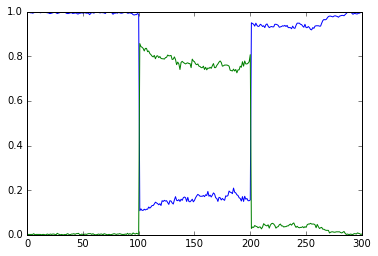

vol = 3e-22, a.concInit = 1.0, a.nInit = 180.664245
Close graph to go to next plot



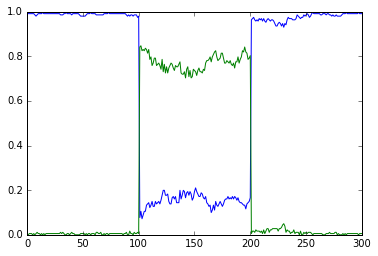

vol = 1e-22, a.concInit = 1.0, a.nInit = 60.221415
Close graph to go to next plot



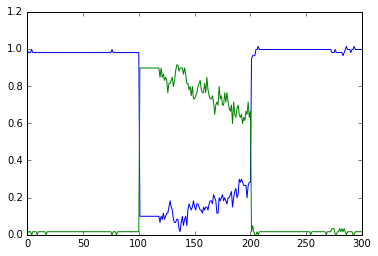

vol = 3e-23, a.concInit = 1.0, a.nInit = 18.0664245
Close graph to go to next plot



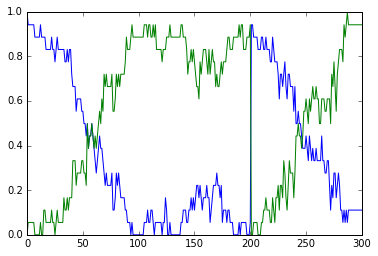

vol = 1e-23, a.concInit = 1.0, a.nInit = 6.0221415
Close graph to go to next plot



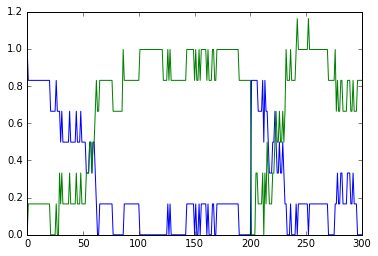

In [1]:
#########################################################################
## This program is part of 'MOOSE', the
## Messaging Object Oriented Simulation Environment.
##           Copyright (C) 2013 Upinder S. Bhalla. and NCBS
## It is made available under the terms of the
## GNU Lesser General Public License version 2.1
## See the file COPYING.LIB for the full notice.
#########################################################################

%matplotlib inline

import math
import pylab
import numpy
import moose

def makeModel():
		# create container for model
		model = moose.Neutral( 'model' )
		compartment = moose.CubeMesh( '/model/compartment' )
		compartment.volume = 1e-20
		# the mesh is created automatically by the compartment
		mesh = moose.element( '/model/compartment/mesh' ) 

		# create molecules and reactions
		a = moose.Pool( '/model/compartment/a' )
		b = moose.Pool( '/model/compartment/b' )
		c = moose.Pool( '/model/compartment/c' )
		enz1 = moose.Enz( '/model/compartment/b/enz1' )
		enz2 = moose.Enz( '/model/compartment/c/enz2' )
		cplx1 = moose.Pool( '/model/compartment/b/enz1/cplx' )
		cplx2 = moose.Pool( '/model/compartment/c/enz2/cplx' )
		reac = moose.Reac( '/model/compartment/reac' )

		# connect them up for reactions
		moose.connect( enz1, 'sub', a, 'reac' )
		moose.connect( enz1, 'prd', b, 'reac' )
		moose.connect( enz1, 'enz', b, 'reac' )
		moose.connect( enz1, 'cplx', cplx1, 'reac' )

		moose.connect( enz2, 'sub', b, 'reac' )
		moose.connect( enz2, 'prd', a, 'reac' )
		moose.connect( enz2, 'enz', c, 'reac' )
		moose.connect( enz2, 'cplx', cplx2, 'reac' )

		moose.connect( reac, 'sub', a, 'reac' )
		moose.connect( reac, 'prd', b, 'reac' )

		# connect them up to the compartment for volumes
		#for x in ( a, b, c, cplx1, cplx2 ):
		#			moose.connect( x, 'mesh', mesh, 'mesh' )

		# Assign parameters
		a.concInit = 1
		b.concInit = 0
		c.concInit = 0.01
		enz1.kcat = 0.4
		enz1.Km = 4
		enz2.kcat = 0.6
		enz2.Km = 0.01
		reac.Kf = 0.001
		reac.Kb = 0.01

		# Create the output tables
		graphs = moose.Neutral( '/model/graphs' )
		outputA = moose.Table ( '/model/graphs/concA' )
		outputB = moose.Table ( '/model/graphs/concB' )

		# connect up the tables
		moose.connect( outputA, 'requestOut', a, 'getConc' );
		moose.connect( outputB, 'requestOut', b, 'getConc' );

		# Schedule the whole lot
		moose.setClock( 4, 0.01 ) # for the computational objects
		moose.setClock( 8, 1.0 ) # for the plots
		# The wildcard uses # for single level, and ## for recursive.
		moose.useClock( 4, '/model/compartment/##', 'process' )
		moose.useClock( 8, '/model/graphs/#', 'process' )

def displayPlots():
		for x in moose.wildcardFind( '/model/graphs/conc#' ):
				t = numpy.arange( 0, x.vector.size, 1 ) #sec
				pylab.plot( t, x.vector, label=x.name )

def main():

    """
    This example illustrates how to run a model at different volumes.
    The key line is just to set the volume of the compartment::

        compt.volume = vol

    If everything
    else is set up correctly, then this change propagates through to all
    reactions molecules.

    For a deterministic reaction one would not see any change in output 
    concentrations.
    For a stochastic reaction illustrated here, one sees the level of 
    'noise' 
    changing, even though the concentrations are similar up to a point.
    This example creates a bistable model having two enzymes and a reaction.
    One of the enzymes is autocatalytic.
    This model is set up within the script rather than using an external 
    file.
    The model is set up to run using the GSSA (Gillespie Stocahstic systems
    algorithim) method in MOOSE.

    To run the example, run the script

        ``python scaleVolumes.py``

    and close the plots every cycle to see the outcome of stochastic
    calculations at ever smaller volumes, keeping concentrations the same.
    """
    makeModel()
    moose.seed( 11111 )
    gsolve = moose.Gsolve( '/model/compartment/gsolve' )
    stoich = moose.Stoich( '/model/compartment/stoich' )
    compt = moose.element( '/model/compartment' );
    stoich.compartment = compt
    stoich.ksolve = gsolve
    stoich.path = "/model/compartment/##"
    moose.setClock( 5, 1.0 ) # clock for the solver
    moose.useClock( 5, '/model/compartment/gsolve', 'process' )
    a = moose.element( '/model/compartment/a' )

    for vol in ( 1e-19, 1e-20, 1e-21, 3e-22, 1e-22, 3e-23, 1e-23 ):
        # Set the volume
        compt.volume = vol
        print('vol = {}, a.concInit = {}, a.nInit = {}'.format( vol, a.concInit, a.nInit))
        print('Close graph to go to next plot\n')

        moose.reinit()
        moose.start( 100.0 ) # Run the model for 100 seconds.

        a = moose.element( '/model/compartment/a' )
        b = moose.element( '/model/compartment/b' )

        # move most molecules over to b
        b.conc = b.conc + a.conc * 0.9
        a.conc = a.conc * 0.1
        moose.start( 100.0 ) # Run the model for 100 seconds.

        # move most molecules back to a
        a.conc = a.conc + b.conc * 0.99
        b.conc = b.conc * 0.01
        moose.start( 100.0 ) # Run the model for 100 seconds.

        # Iterate through all plots, dump their contents to data.plot.
        displayPlots()
        pylab.show()

    quit()

# Run the 'main' if this script is executed standalone.
if __name__ == '__main__':
	main()
